# Dependent Variable: Collaboration

#### Has the introduction of ChatGPT increased collaboration among Software Developers?
1. Contribution >> Count Forks
2. Commit Frequency >> Count push/pull Events
3. Commit diversity >> count unique contributers per repository

# Key Takeaways - Data Distribution

#### Concentration of Activity, Skewed Distribution, Disparate Engagement
- Significant centralization within a few repositories, coupled with a high degree of data asymmetry, highlighting both selectivity in community engagement and a disproportionate focus on a minimal number of projects. 
- Predominance of repositories with minimal activity, indicating that numerous projects may be personal, experimental, or in early stages of development.

#### Implications
- Applying stratified sampling techniques, such as categorizing repositories into high/medium/low-activity segments, alongside employing specialized statistical methodologies tailored for skewed distributions. 
- Prioritizing data filtering and robust analytical techniques to differentiate dormant or less popular projects from those with genuine user engagement, ensuring the research focuses on meaningful activity without being overwhelmed by the volume of low-activity data.

In [119]:
import pandas as pd
import json
import gzip
import io
import time
from github import Github
import fuzzywuzzy
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import requests
import os
import sys
from config import config
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

#### Import Sample from GitHub Archive, Display Data Structure and Group by Repository
- 163.000 rows of commits
- 62.000 unique repositories

In [117]:
access_token = config.ACCESS_TOKEN
github_token = config.GITHUB_TOKEN

In [120]:
# Ensure the 'data' folder exists
if not os.path.exists('data'):
    os.makedirs('data')
    
start = datetime(2023, 4, 1, 15)  # year, month, day, hour
end = datetime(2023, 4, 1, 18)  # year, month, day, hour

# Generate the hours between the start and end dates
hours = int((end - start).total_seconds() / 3600)
dates = [start + timedelta(hours=i) for i in range(hours + 1)]  # '+1' to include the end hour

# Download the data for each hour in the range and skip download if the file already exists
for date in dates:
    date_str = date.strftime('%Y-%m-%d-%H')
    url = f'https://data.gharchive.org/{date_str}.json.gz'
    file_path = os.path.join('data', f'{date_str}.json.gz')
    
    if os.path.exists(file_path):
        print(f"The file already exists at {file_path}. No need to download.")
        continue

    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(file_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=128):
                file.write(chunk)
        print(f"File downloaded successfully and saved to {file_path}")
    else:
        print("Failed to fetch the file")

The file already exists at data\2023-04-01-15.json.gz. No need to download.
File downloaded successfully and saved to data\2023-04-01-16.json.gz
File downloaded successfully and saved to data\2023-04-01-17.json.gz
File downloaded successfully and saved to data\2023-04-01-18.json.gz


In [130]:
# Combining all the collected data into a single DataFrame
dfs = []
files = [f for f in os.listdir('data') if f.endswith('.json.gz')]
for file_name in files:
    file_path = os.path.join('data', file_name)
    with gzip.open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]
    df = pd.DataFrame(data)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
print("Data concatenation completed.")

Data concatenation completed.


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623996 entries, 0 to 623995
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          623996 non-null  object
 1   type        623996 non-null  object
 2   actor       623996 non-null  object
 3   repo        623996 non-null  object
 4   payload     623996 non-null  object
 5   public      623996 non-null  bool  
 6   created_at  623996 non-null  object
 7   org         136542 non-null  object
dtypes: bool(1), object(7)
memory usage: 33.9+ MB


In [132]:
commits = df
commits.head()

,id,type,actor,repo,payload,public,created_at,org
0,28137501092,PushEvent,"{'id': 41898282, 'login': 'github-actions[bot]...","{'id': 568277185, 'name': 'stdlib-js/strided-b...","{'repository_id': 568277185, 'push_id': 131547...",True,2023-04-01T15:00:00Z,"{'id': 17805691, 'login': 'stdlib-js', 'gravat..."
1,28137501094,CreateEvent,"{'id': 115239975, 'login': 'ishuduwal', 'displ...","{'id': 622248753, 'name': 'ishuduwal/personal-...","{'ref': 'main', 'ref_type': 'branch', 'master_...",True,2023-04-01T15:00:00Z,NaN
2,28137501097,CreateEvent,"{'id': 50960481, 'login': 'bxbao87', 'display_...","{'id': 622248756, 'name': 'bxbao87/bloglist', ...","{'ref': 'main', 'ref_type': 'branch', 'master_...",True,2023-04-01T15:00:00Z,NaN
3,28137501098,PushEvent,"{'id': 52915358, 'login': 'alwaz-shahid', 'dis...","{'id': 622201481, 'name': 'alwaz-shahid/extens...","{'repository_id': 622201481, 'push_id': 131547...",True,2023-04-01T15:00:00Z,NaN
4,28137501099,CreateEvent,"{'id': 101326737, 'login': 'HOVADOVOLE', 'disp...","{'id': 622248605, 'name': 'HOVADOVOLE/Serial-P...","{'ref': 'main', 'ref_type': 'branch', 'master_...",True,2023-04-01T15:00:00Z,NaN


In [133]:
pd.json_normalize(commits['actor'])

,id,login,display_login,gravatar_id,url,avatar_url
0,41898282,github-actions[bot],github-actions,,https://api.github.com/users/github-actions[bot],https://avatars.githubusercontent.com/u/41898282?
1,115239975,ishuduwal,ishuduwal,,https://api.github.com/users/ishuduwal,https://avatars.githubusercontent.com/u/115239...
2,50960481,bxbao87,bxbao87,,https://api.github.com/users/bxbao87,https://avatars.githubusercontent.com/u/50960481?
3,52915358,alwaz-shahid,alwaz-shahid,,https://api.github.com/users/alwaz-shahid,https://avatars.githubusercontent.com/u/52915358?
4,101326737,HOVADOVOLE,HOVADOVOLE,,https://api.github.com/users/HOVADOVOLE,https://avatars.githubusercontent.com/u/101326...
...,...,...,...,...,...,...
623991,44135514,vodemn,vodemn,,https://api.github.com/users/vodemn,https://avatars.githubusercontent.com/u/44135514?
623992,35613825,vercel[bot],vercel,,https://api.github.com/users/vercel[bot],https://avatars.githubusercontent.com/u/35613825?
623993,32931701,SuhEugene,SuhEugene,,https://api.github.com/users/SuhEugene,https://avatars.githubusercontent.com/u/32931701?
623994,32931701,SuhEugene,SuhEugene,,https://api.github.com/users/SuhEugene,https://avatars.githubusercontent.com/u/32931701?


In [136]:
pd.json_normalize(commits['repo'])

,id,name,url
0,568277185,stdlib-js/strided-base-mskunary-signature-call...,https://api.github.com/repos/stdlib-js/strided...
1,622248753,ishuduwal/personal-website,https://api.github.com/repos/ishuduwal/persona...
2,622248756,bxbao87/bloglist,https://api.github.com/repos/bxbao87/bloglist
3,622201481,alwaz-shahid/extension-firefox-get-tabs,https://api.github.com/repos/alwaz-shahid/exte...
4,622248605,HOVADOVOLE/Serial-Parallel_Pi_PVA,https://api.github.com/repos/HOVADOVOLE/Serial...
...,...,...,...
623991,551944111,vodemn/m3_lightmeter,https://api.github.com/repos/vodemn/m3_lightmeter
623992,620995394,GiftOfHell/EtacarTestTask,https://api.github.com/repos/GiftOfHell/Etacar...
623993,600199670,SierraBay/SierraBay12,https://api.github.com/repos/SierraBay/SierraB...
623994,600199670,SierraBay/SierraBay12,https://api.github.com/repos/SierraBay/SierraB...


In [135]:
pd.json_normalize(df['org'])

,id,login,gravatar_id,url,avatar_url
0,17805691.0,stdlib-js,,https://api.github.com/orgs/stdlib-js,https://avatars.githubusercontent.com/u/17805691?
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
623991,NaN,NaN,NaN,NaN,NaN
623992,NaN,NaN,NaN,NaN,NaN
623993,125086274.0,SierraBay,,https://api.github.com/orgs/SierraBay,https://avatars.githubusercontent.com/u/125086...
623994,125086274.0,SierraBay,,https://api.github.com/orgs/SierraBay,https://avatars.githubusercontent.com/u/125086...


In [137]:
#frequency of top-level keys 
key_counts = {}
for payload in commits['payload']:
    for key in payload.keys():
        key_counts[key] = key_counts.get(key, 0) + 1
key_counts = sorted(key_counts.items(), key=lambda x: x[1])
key_counts

[('pages', 1125),
 ('member', 2180),
 ('release', 3498),
 ('review', 8506),
 ('forkee', 10611),
 ('issue', 35286),
 ('comment', 35788),
 ('number', 42856),
 ('pull_request', 56653),
 ('master_branch', 86930),
 ('description', 86930),
 ('ref_type', 104707),
 ('pusher_type', 104707),
 ('action', 135689),
 ('repository_id', 361549),
 ('push_id', 361549),
 ('size', 361549),
 ('distinct_size', 361549),
 ('head', 361549),
 ('before', 361549),
 ('commits', 361549),
 ('ref', 466256)]

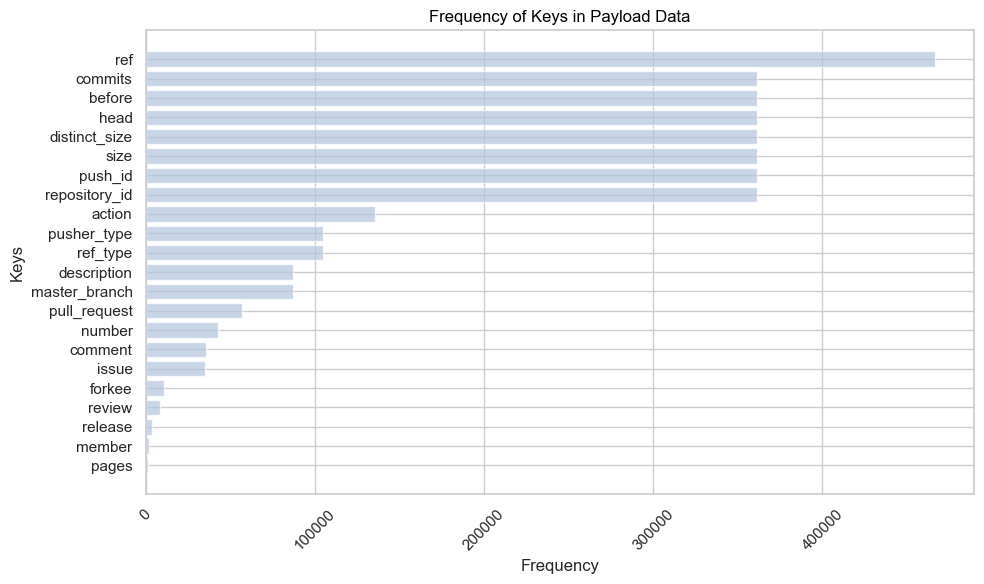

In [138]:
keys = [item[0] for item in key_counts]
values =  [item[1] for item in key_counts]

plt.figure(figsize=(10,6))
plt.barh(keys, values, color='#B0C4DE', alpha=0.7) 
plt.ylabel('Keys')
plt.xlabel('Frequency')
plt.title('Frequency of Keys in Payload Data')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Calculate different metrics to measure collaboration on repository-level and store in new df 'repos'

In [139]:
# Extracting repository name and id for easy grouping
commits['repo_name'] = commits['repo'].apply(lambda x: x['name'])
commits['repo_id'] = commits['repo'].apply(lambda x: x['id'])
commits['actor_login'] = commits['actor'].apply(lambda x: x['login'])

# Calculating metrics
grouped = commits.groupby(['repo_name', 'repo_id'])

forks_per_repo = grouped.apply(lambda x: (x['type'] == 'ForkEvent').sum())
push_per_repo = grouped.apply(lambda x: (x['type'] == 'PushEvent').sum())
pull_per_repo = grouped.apply(lambda x: (x['type'] == 'PullRequestEvent').sum())
unique_contributors_per_repo = grouped['actor_login'].nunique()
total_contributors_per_repo = grouped['actor_login'].size()

# Combining metrics into a new dataframe
repos = pd.DataFrame({
    'Forks': forks_per_repo,
    'Pushes': push_per_repo,
    'Pulls': pull_per_repo,
    'UniqueContributors': unique_contributors_per_repo,
    'TotalContributions': total_contributors_per_repo,
}).reset_index()
repos.head()

,repo_name,repo_id,Forks,Pushes,Pulls,UniqueContributors,TotalContributions
0,0-AutomationCode/tab-icons,597952501,0,1,0,1,1
1,0-BSCode/0-BSCode,532507797,0,1,0,1,1
2,0-haha/earthquake_notification,622288089,0,3,0,1,5
3,0-vortex/0-vortex,279163614,0,4,0,1,4
4,0-vortex/rss-feed-parser,451964411,0,34,0,1,34


In [141]:
repos.describe()

,repo_id,Forks,Pushes,Pulls,UniqueContributors,TotalContributions
count,1.794850e+05,179485.000000,179485.000000,179485.000000,179485.000000,179485.000000
mean,5.024505e+08,0.059119,2.014369,0.238772,1.216063,3.476591
std,1.733511e+08,1.262379,21.629790,2.006832,7.087393,24.918981
min,1.300000e+02,0.000000,0.000000,0.000000,1.000000,1.000000
25%,4.380720e+08,0.000000,0.000000,0.000000,1.000000,1.000000
50%,6.008919e+08,0.000000,1.000000,0.000000,1.000000,2.000000
75%,6.218311e+08,0.000000,2.000000,0.000000,1.000000,3.000000
max,6.223206e+08,474.000000,4872.000000,633.000000,2844.000000,4872.000000


### Visualisations

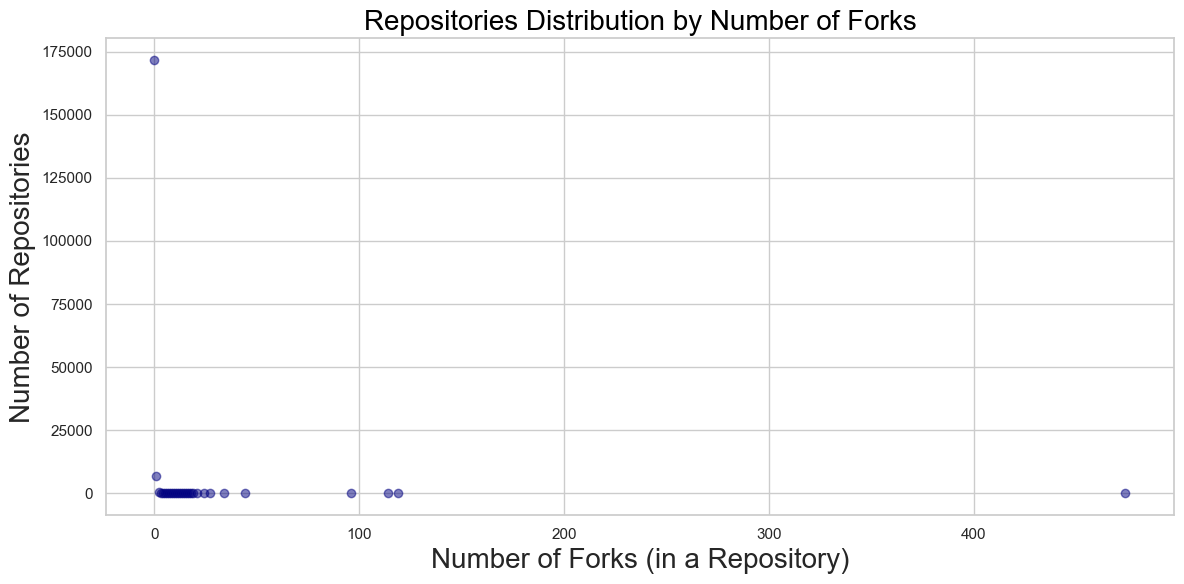

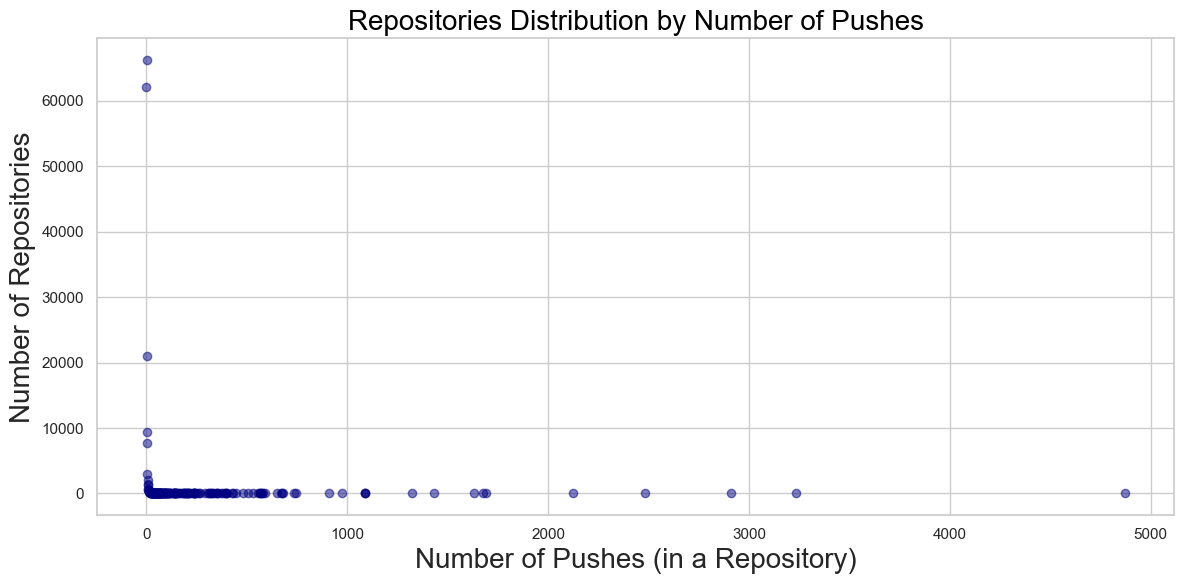

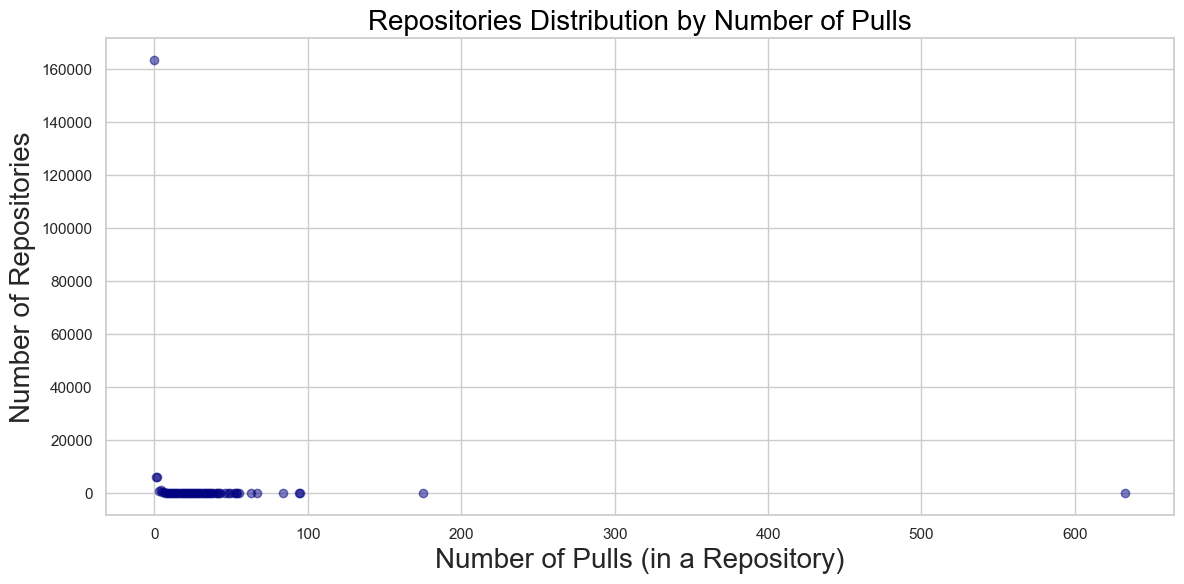

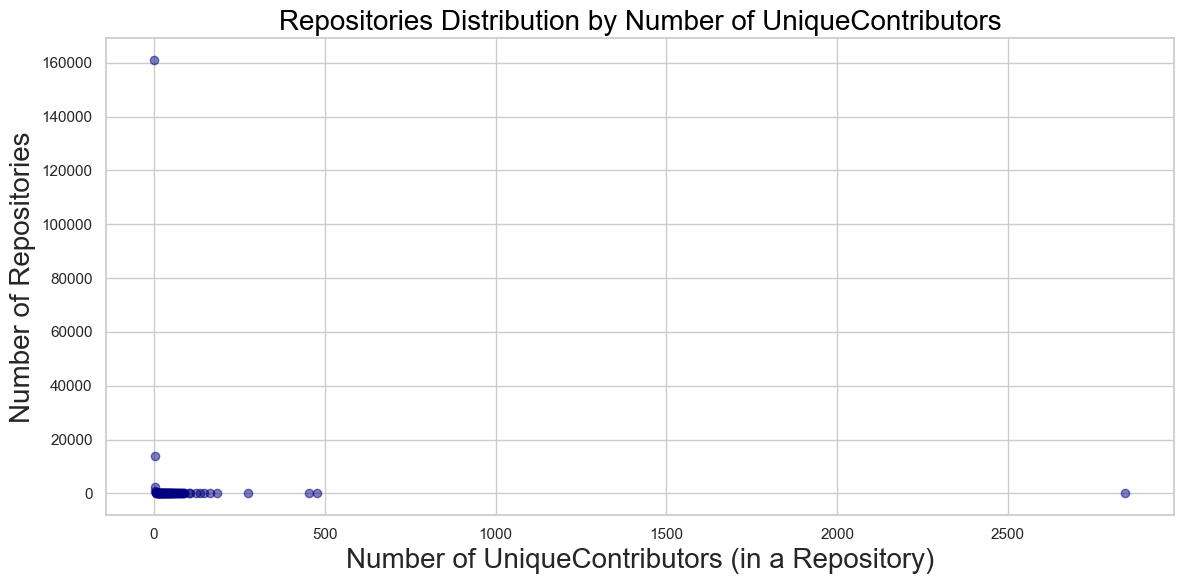

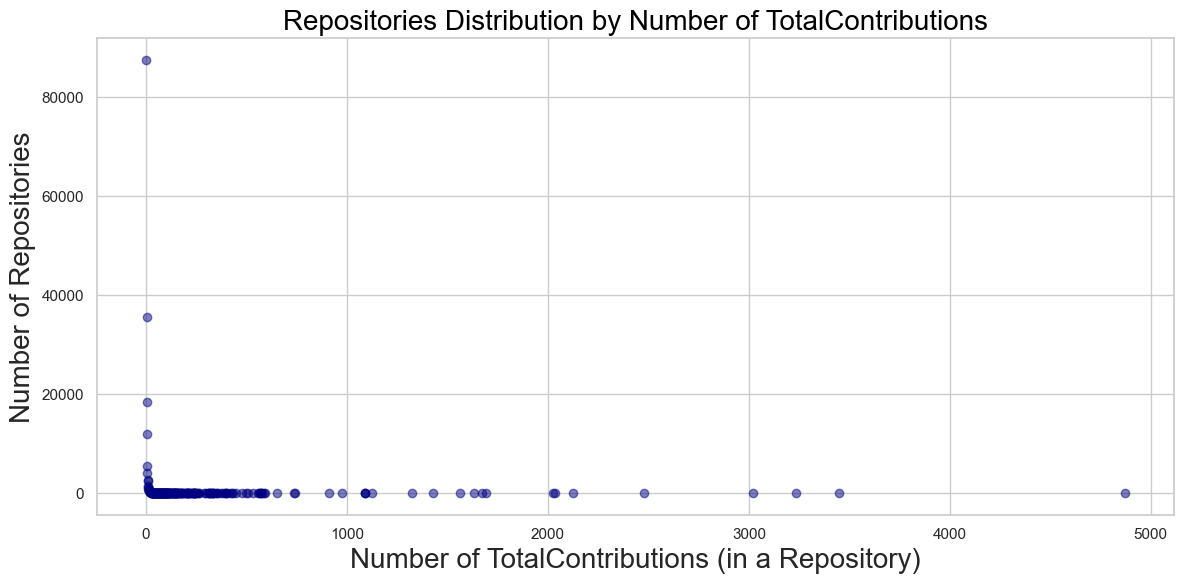

In [142]:
sns.set_theme(style="whitegrid")
metrics = ['Forks', 'Pushes', 'Pulls', 'UniqueContributors', 'TotalContributions']
for metric in metrics:
    plt.figure(figsize=(12, 6))
    value_counts = repos[metric].value_counts().sort_index()
    plt.scatter(value_counts.index, value_counts.values, alpha=0.5, color='navy')
    plt.title(f'Repositories Distribution by Number of {metric}', fontsize=20)
    plt.xlabel(f'Number of {metric} (in a Repository)', fontsize=20)
    plt.ylabel(f'Number of Repositories', fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

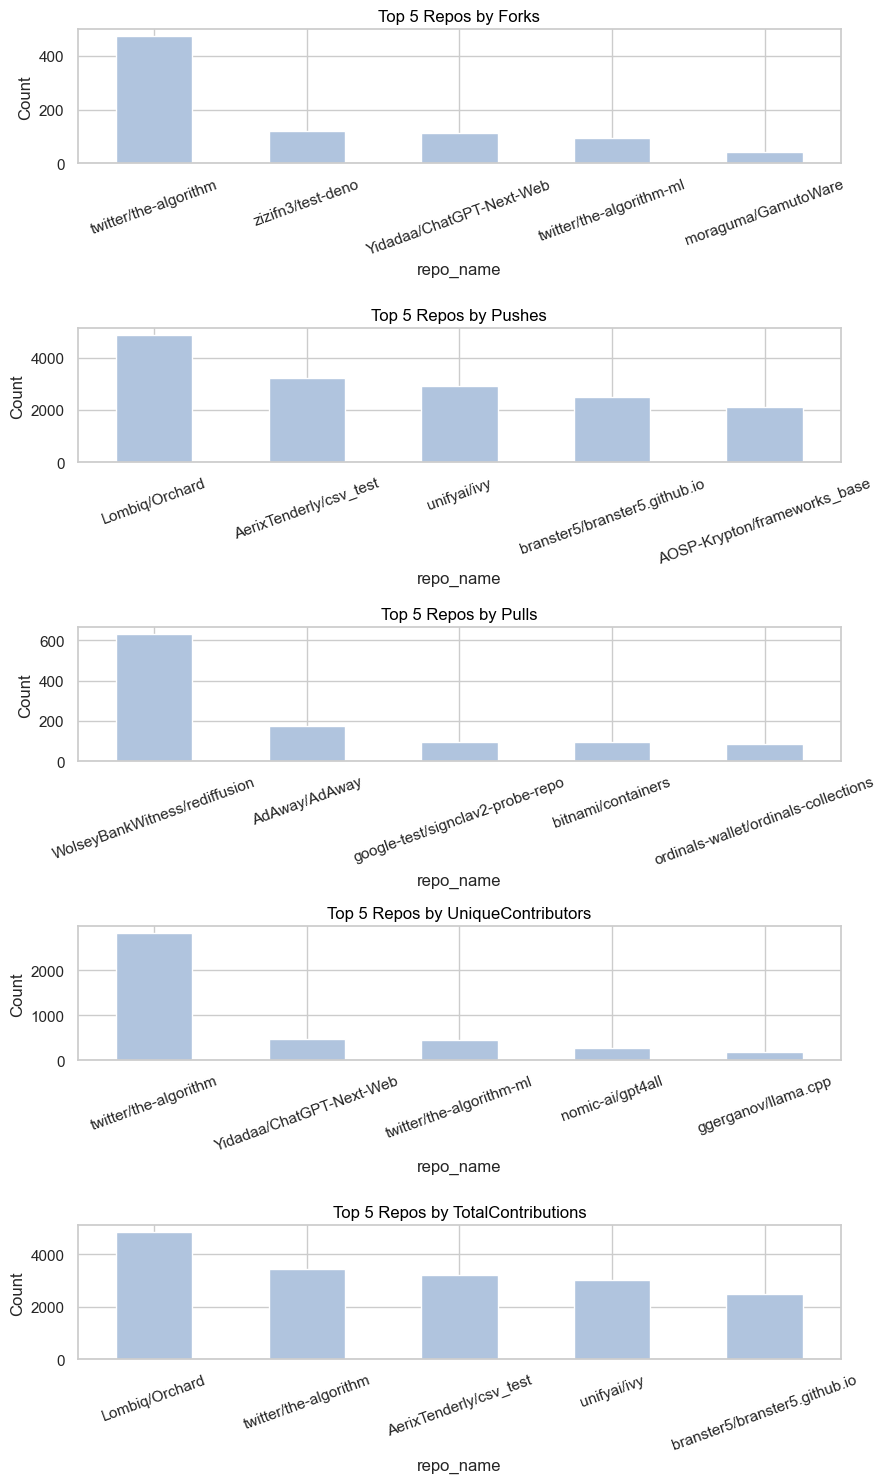

In [147]:
plt.figure(figsize=(17, 3 * len(metrics)))  

for index, metric in enumerate(metrics):
    plt.subplot(len(metrics), 2, 2*index + 2)
    repos_sorted = repos.sort_values(by=metric, ascending=False)
    repos_sorted.set_index('repo_name').head(5)[metric].plot(kind='bar', color=light_blue)
    plt.title(f'Top 5 Repos by {metric}')
    plt.ylabel('Count')
    plt.xticks(rotation=20)
    
plt.tight_layout()
plt.show()

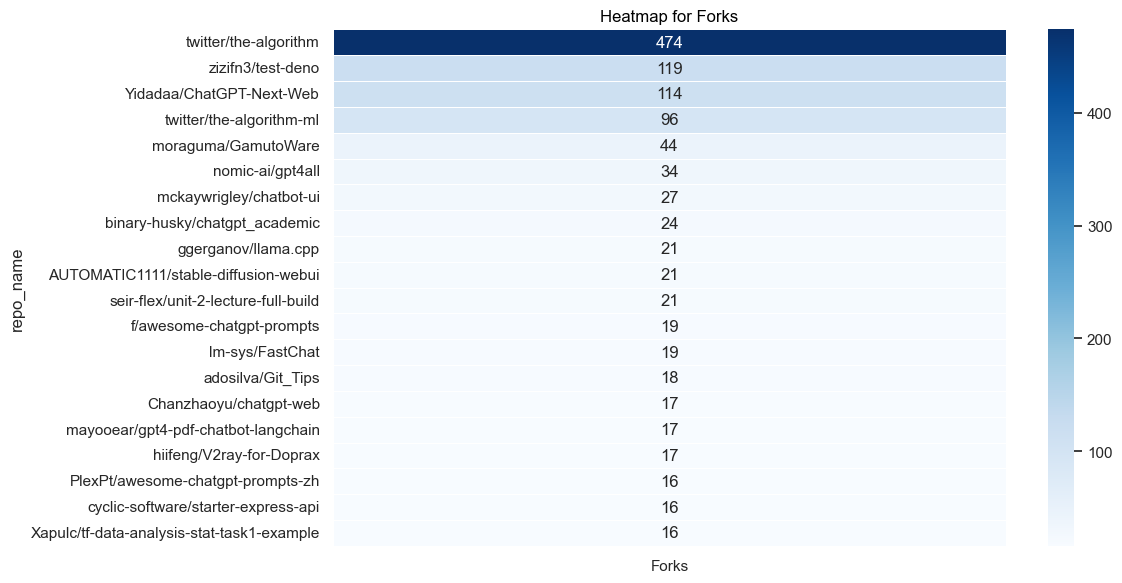

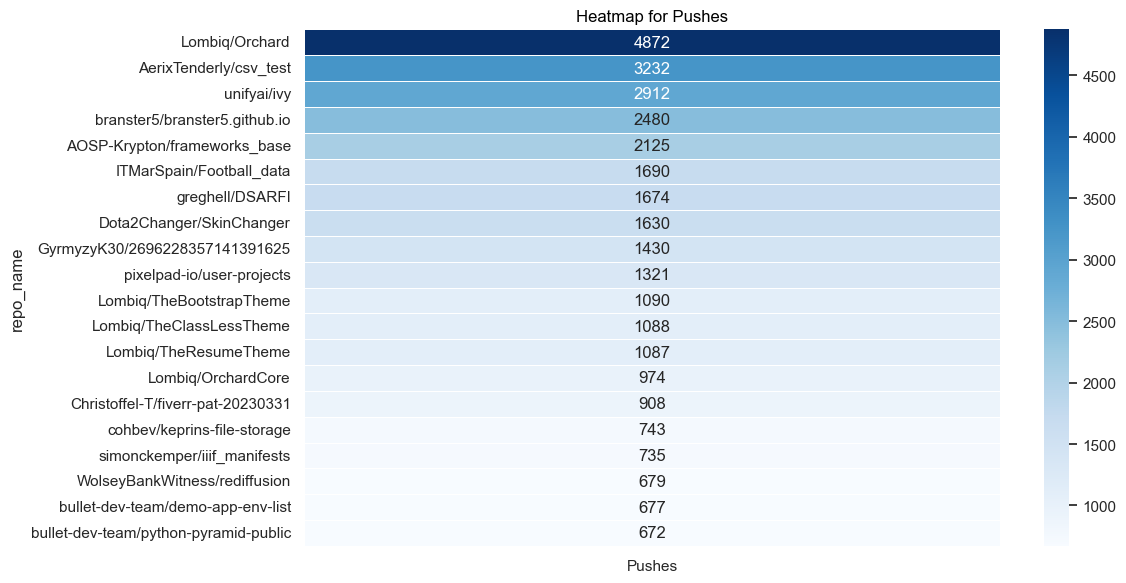

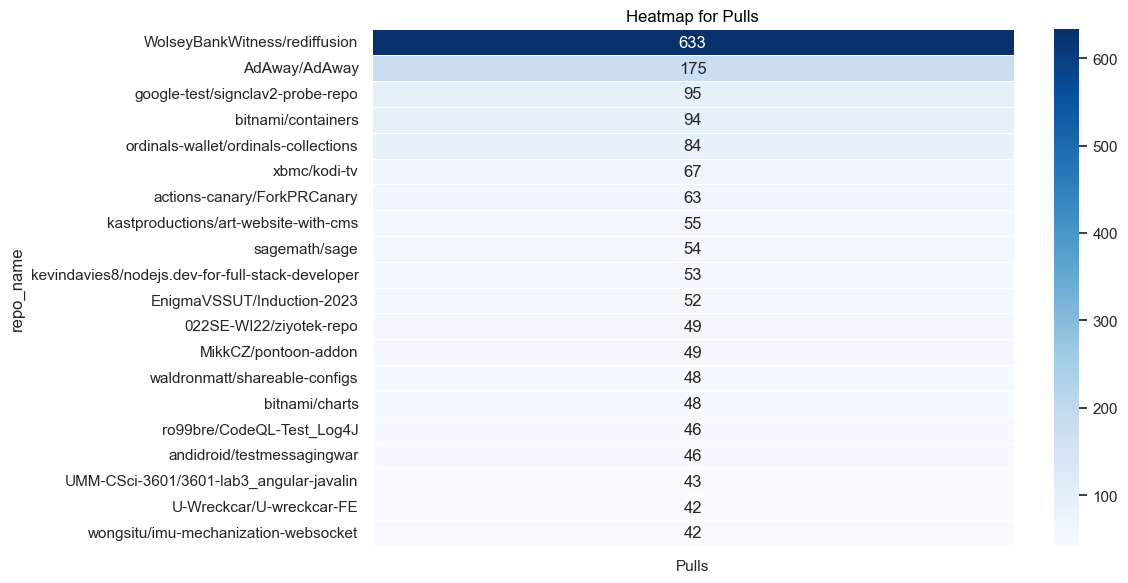

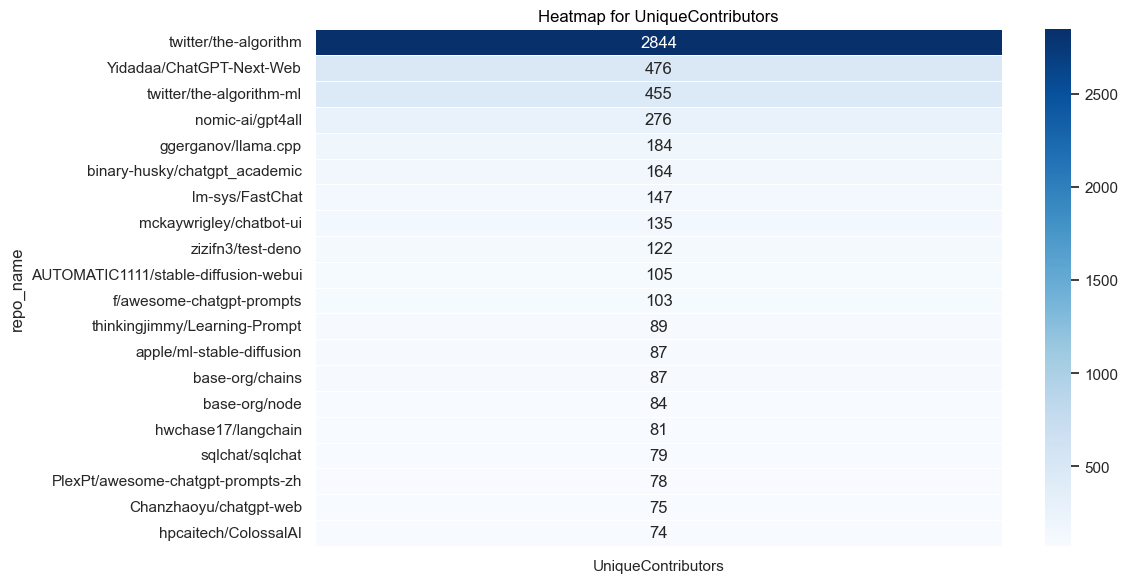

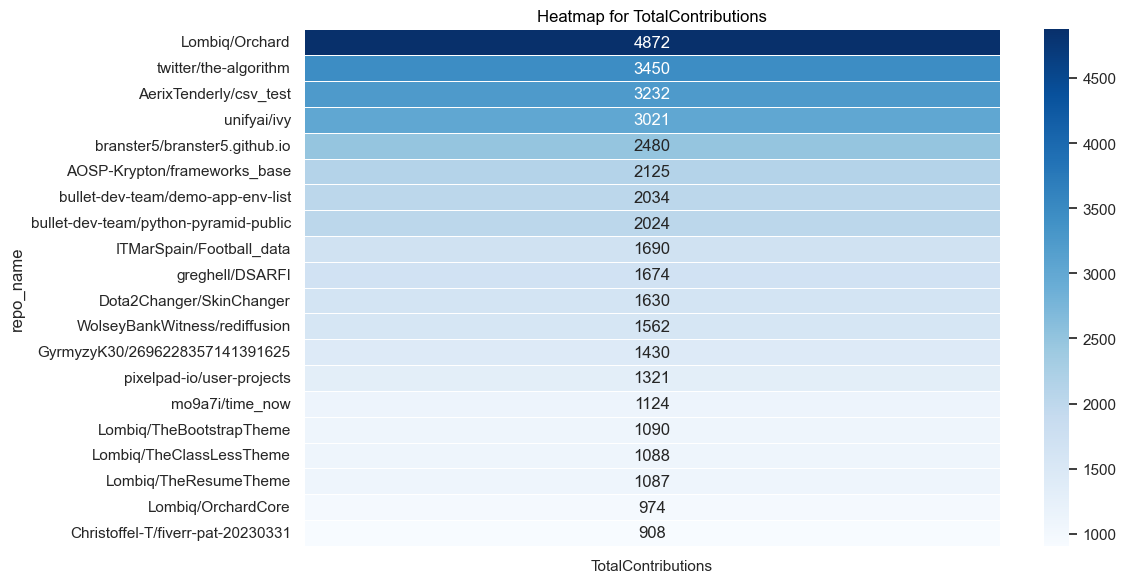

In [148]:
sns.set_palette("light:#B0C4DE")

for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.heatmap(repos.pivot_table(index='repo_name', values=metric, aggfunc='sum').sort_values(by=metric, ascending=False).head(20), annot=True, fmt="g", cmap='Blues', linewidths=.5)
    plt.title(f'Heatmap for {metric}')
    plt.tight_layout()
    plt.show()